Handwritten feature prediction for personality trait analysis

Project overview
The aim of this project is to predict five personality traits of individuals (openness, conscientiousness, extroversion, agreeableness, neuroticism) by analyzing handwritten features. Establish a multi-objective regression model using machine learning methods, evaluate the performance of different algorithms, and analyze the importance of features.

Data set
-Contains various features of handwritten samples, such as stroke pressure, letter size, spacing, etc
-Target variables: Big Five personality trait scores (Openness, Conscientiousness, Extraversion, Agrability, Neuroticism)

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [12]:
# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_theme(style="whitegrid", palette="husl")

# Load dataset
df = pd.read_csv('handwriting_personality_large_dataset.csv')
print("Data dimension:", df.shape)
print("\nThe first 5 rows of data:")
display(df.head())

Data dimension: (2000, 24)

The first 5 rows of data:


,Handwriting_Sample,Writing_Speed_wpm,Openness,Conscientiousness,Extraversion,Agreeableness,Neuroticism,Gender,Age,Feature_Slant angle of handwriting,...,Feature_Stroke smoothness,Feature_Word spacing variability,Feature_Letter size consistency,Feature_Pen lift frequency,Feature_Overall legibility score,Feature_Cursive vs. print writing tendency,Feature_Speed fluctuations (within a single sentence),Feature_Pen tilt direction,Feature_Ink darkness variation,Feature_Number of strokes per letter
0,sample_1.jpg,60,0.357203,0.407442,0.724947,0.451517,0.255107,Male,45,0.146139,...,0.985927,0.745626,0.923922,0.039155,0.277361,0.832098,0.319128,0.199213,0.241081,0.375978
1,sample_2.jpg,32,0.730250,0.051950,0.351615,0.528413,0.664159,Male,36,0.802833,...,0.893979,0.114380,0.484167,0.022397,0.436322,0.908627,0.220744,0.650947,0.568464,0.660062
2,sample_3.jpg,10,0.836987,0.162227,0.164681,0.816008,0.681870,Other,34,0.452513,...,0.941274,0.950571,0.485661,0.277388,0.873560,0.566973,0.205402,0.537800,0.323519,0.373358
3,sample_4.jpg,12,0.413419,0.363059,0.131564,0.938350,0.236702,Male,26,0.832662,...,0.831041,0.217244,0.351701,0.464859,0.867758,0.298407,0.350210,0.591122,0.802049,0.131324
4,sample_5.jpg,11,0.616046,0.247899,0.909740,0.698966,0.463774,Other,57,0.927785,...,0.797505,0.186378,0.113623,0.299514,0.295555,0.365065,0.210633,0.723195,0.044085,0.014351


2. Exploratory Data Analysis (EDA)

In [15]:
# Check for missing values
print("Missing value statistics:")
display(df.isnull().sum())

# Check data type
print("\nData type:")
display(df.dtypes)

Missing value statistics:


Handwriting_Sample                                       0
Writing_Speed_wpm                                        0
Openness                                                 0
Conscientiousness                                        0
Extraversion                                             0
Agreeableness                                            0
Neuroticism                                              0
Gender                                                   0
Age                                                      0
Feature_Slant angle of handwriting                       0
Feature_Letter spacing consistency                       0
Feature_Letter spacing consistency.1                     0
Feature_Line alignment (straight or curved writing)      0
Feature_Loop formation in letters                        0
Feature_Stroke smoothness                                0
Feature_Word spacing variability                         0
Feature_Letter size consistency                         


Data type:


Handwriting_Sample                                        object
Writing_Speed_wpm                                          int64
Openness                                                 float64
Conscientiousness                                        float64
Extraversion                                             float64
Agreeableness                                            float64
Neuroticism                                              float64
Gender                                                    object
Age                                                        int64
Feature_Slant angle of handwriting                       float64
Feature_Letter spacing consistency                       float64
Feature_Letter spacing consistency.1                     float64
Feature_Line alignment (straight or curved writing)      float64
Feature_Loop formation in letters                        float64
Feature_Stroke smoothness                                float64
Feature_Word spacing vari

Target variable distribution

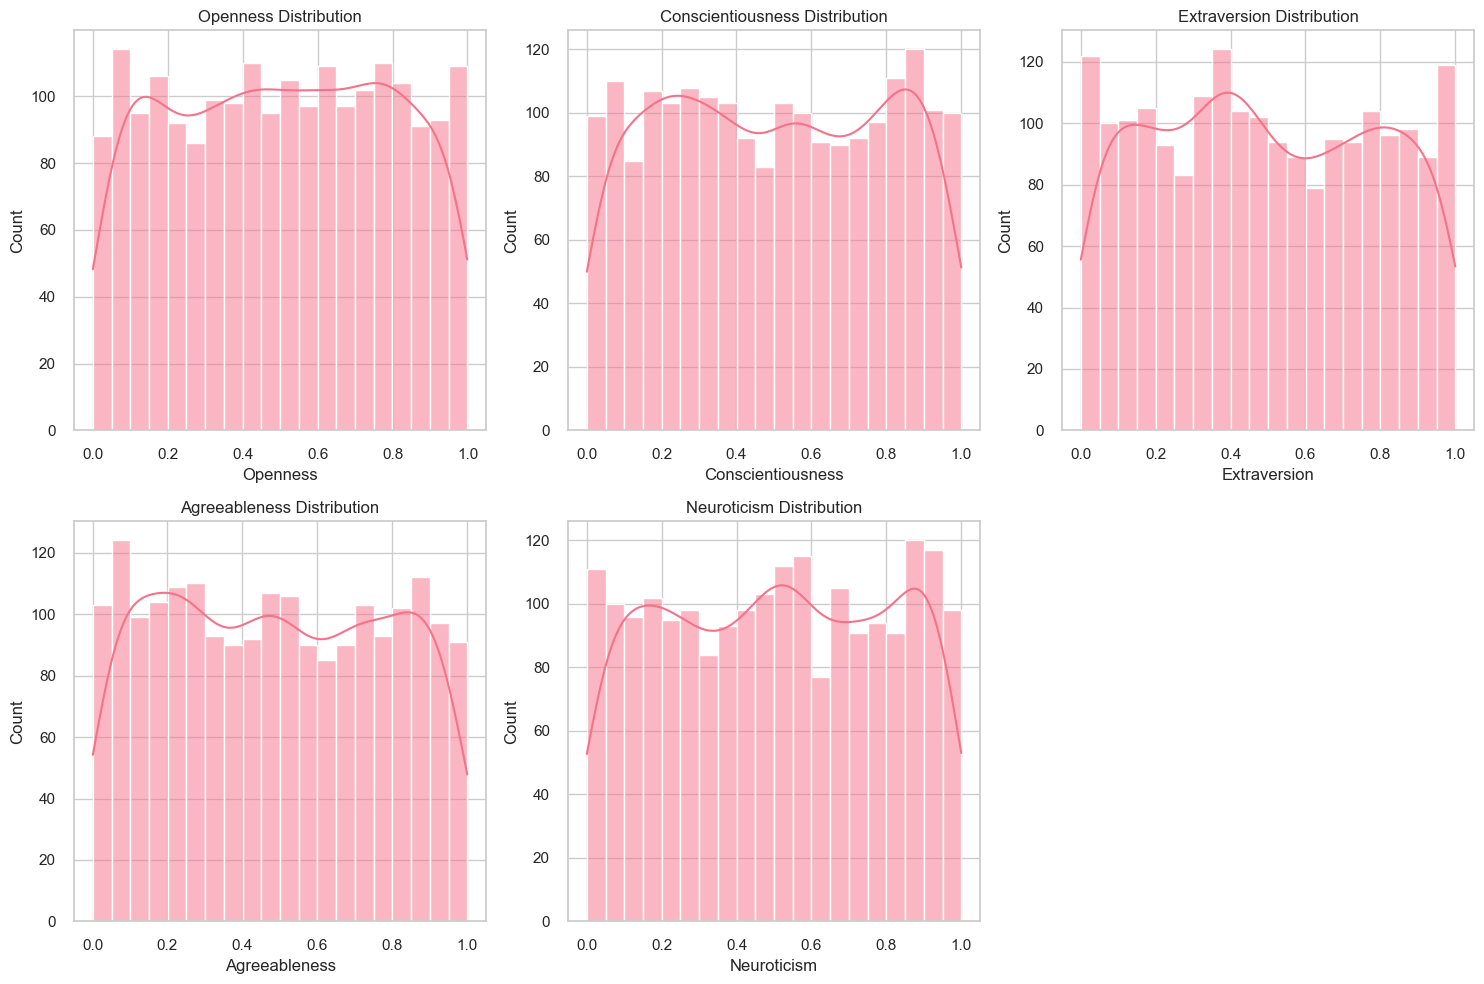

In [18]:
# Visualization of target variable distribution
plt.figure(figsize=(15, 10))
for i, trait in enumerate(['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism']):
    plt.subplot(2, 3, i+1)
    sns.histplot(df[trait], kde=True, bins=20)
    plt.title(f'{trait} Distribution')
plt.tight_layout()
plt.show()

Numerical feature distribution and correlation

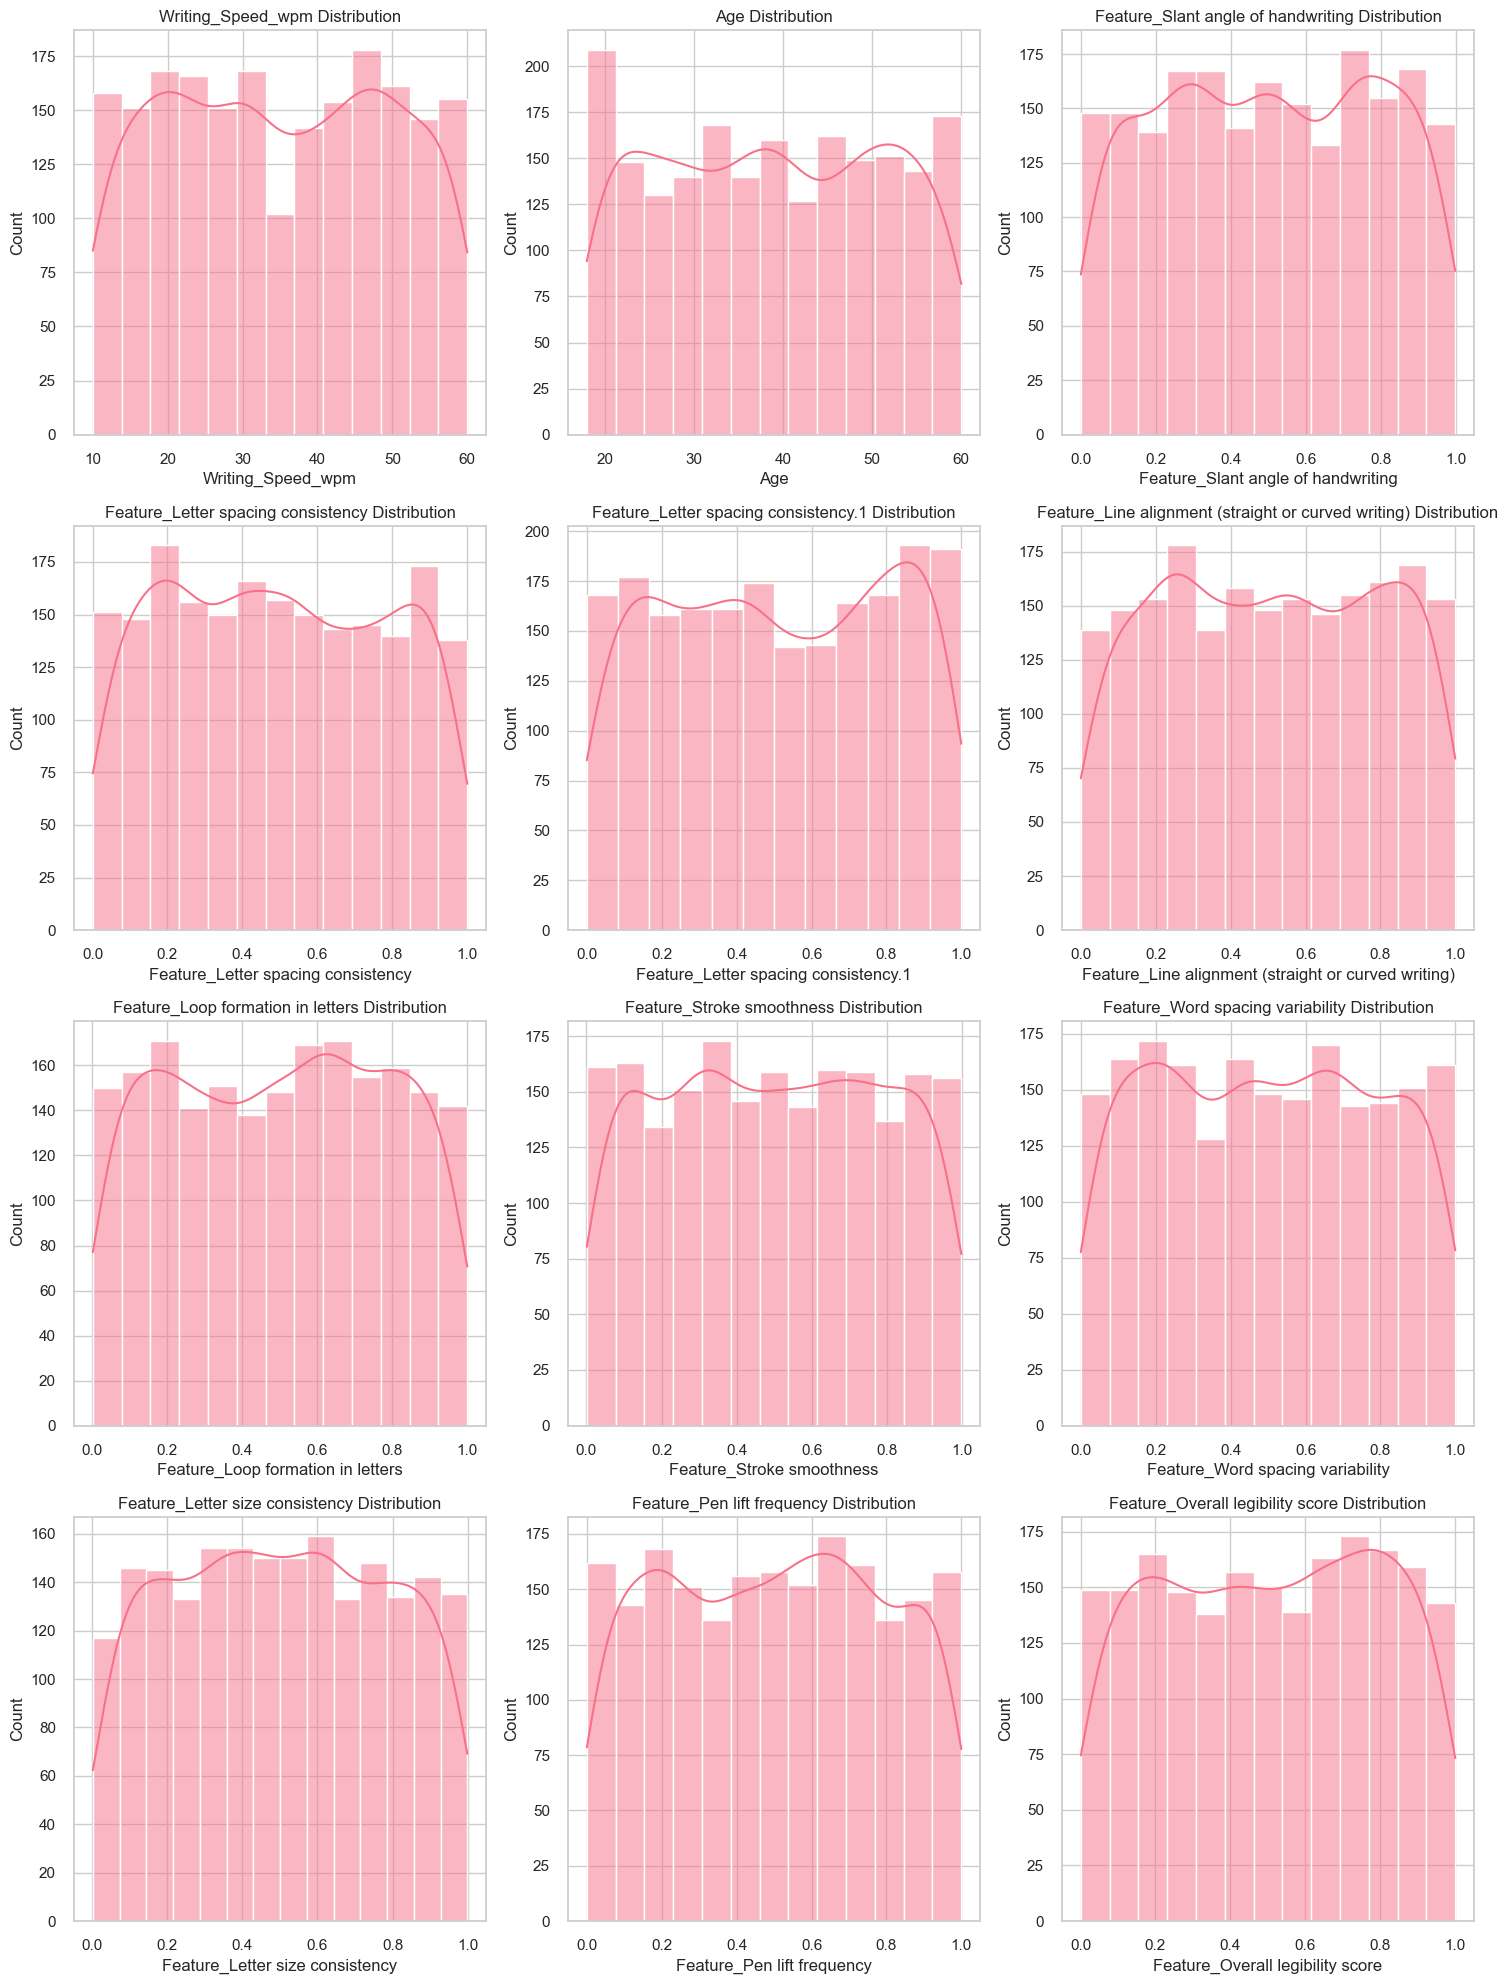

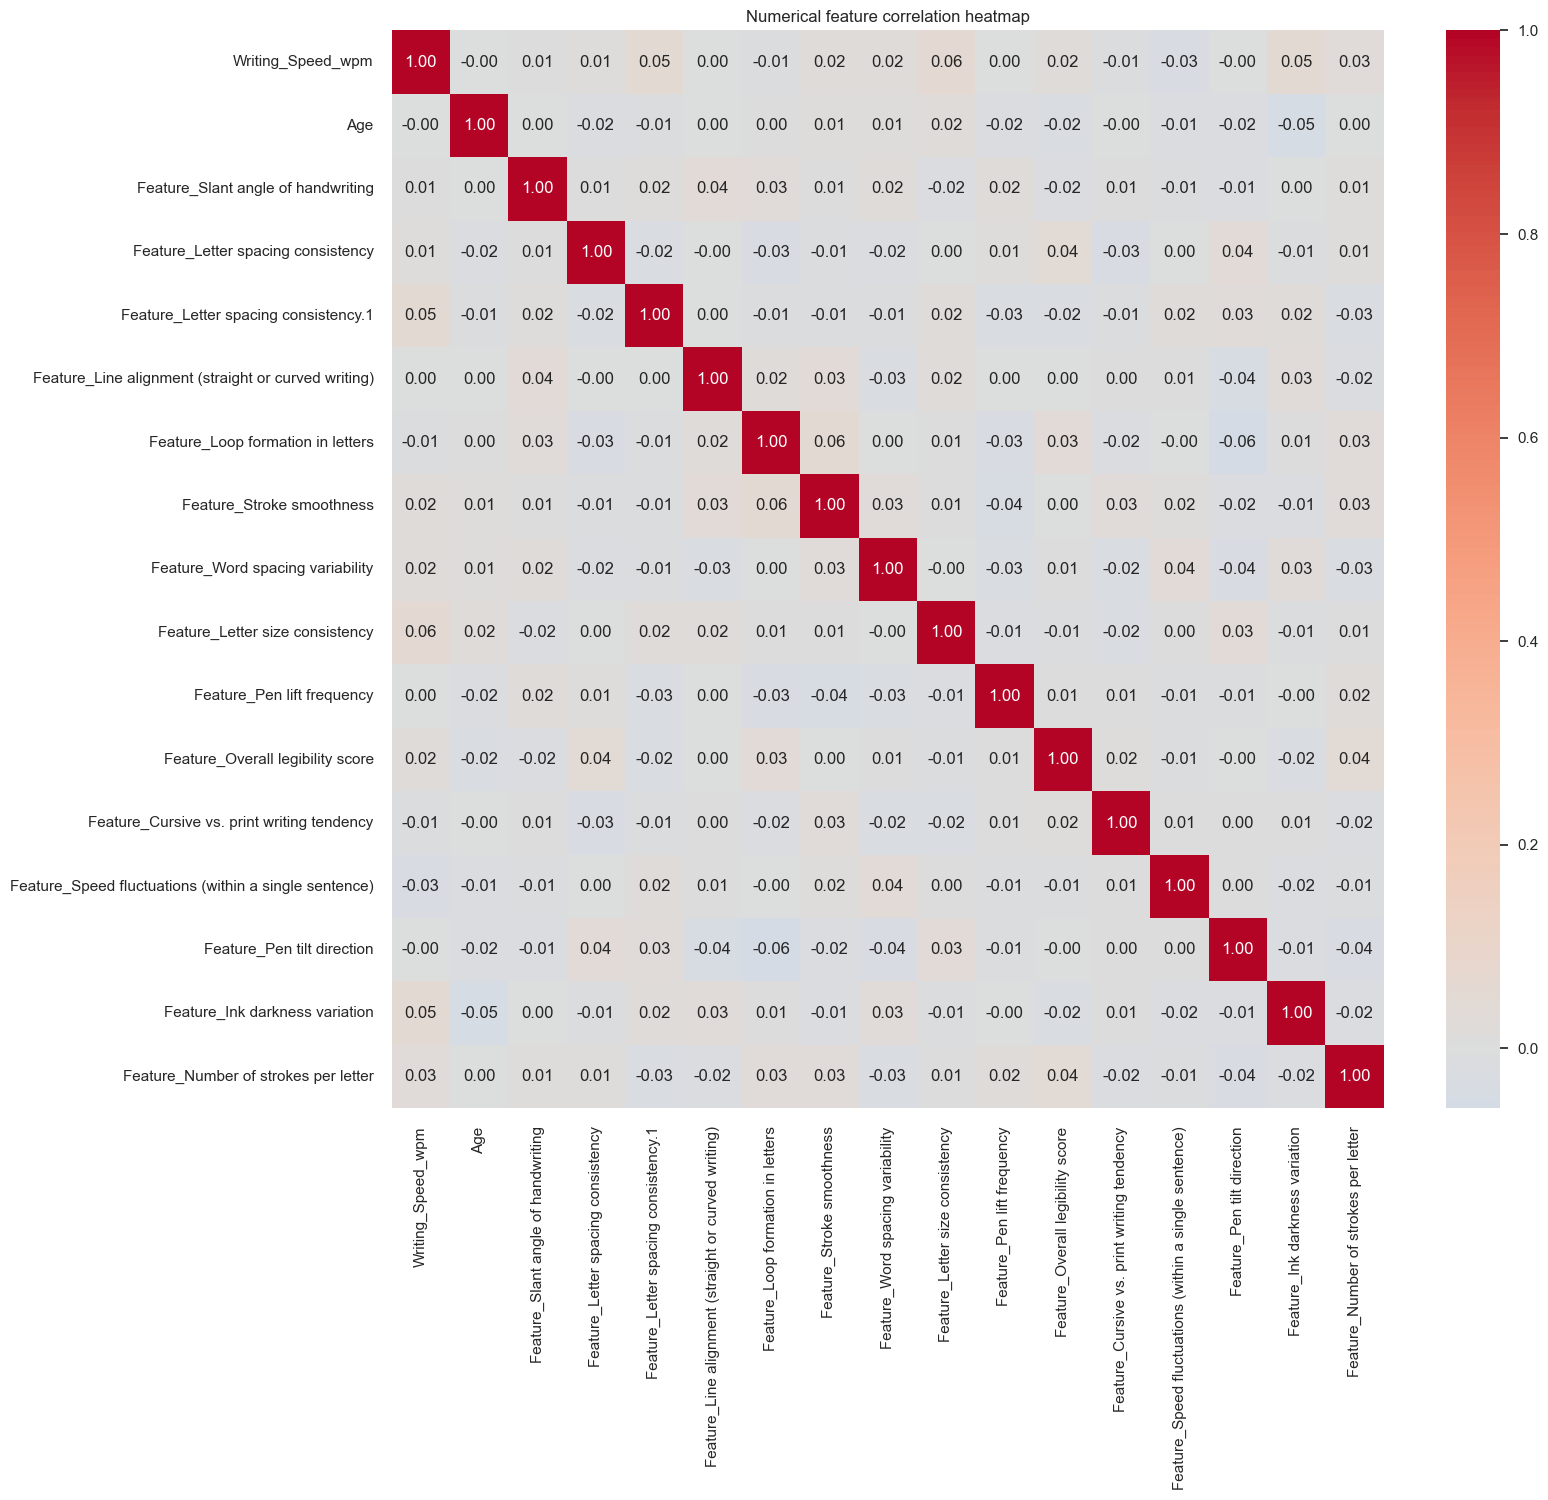

In [21]:
# Select numerical features
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns
numeric_features = [f for f in numeric_features if f not in ['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism']]

# Numerical characteristic distribution
plt.figure(figsize=(15, 20))
for i, feature in enumerate(numeric_features[:12]):  # Only display the first 12 features
    plt.subplot(4, 3, i+1)
    sns.histplot(df[feature], kde=True)
    plt.title(f'{feature} Distribution')
plt.tight_layout()
plt.show()

# Feature correlation heatmap
plt.figure(figsize=(16, 14))
corr_matrix = df[numeric_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Numerical feature correlation heatmap')
plt.show()

3. Data preprocessing

In [24]:
# Define preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, ['Gender'])
    ])

# Separate features and targets
X = df.drop(['Handwriting_Sample', 'Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism'], axis=1)
y = df[['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism']]

# Data segmentation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Application preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Obtain feature names
numeric_features_processed = numeric_features
categorical_features_processed = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(['Gender'])
feature_names = list(numeric_features_processed) + list(categorical_features_processed)

print(f"Training set shape: {X_train_processed.shape}")
print(f"Test set shape: {X_test_processed.shape}")

Training set shape: (1600, 20)
Test set shape: (400, 20)


4. Model training and evaluation


Training in progress Random Forest...


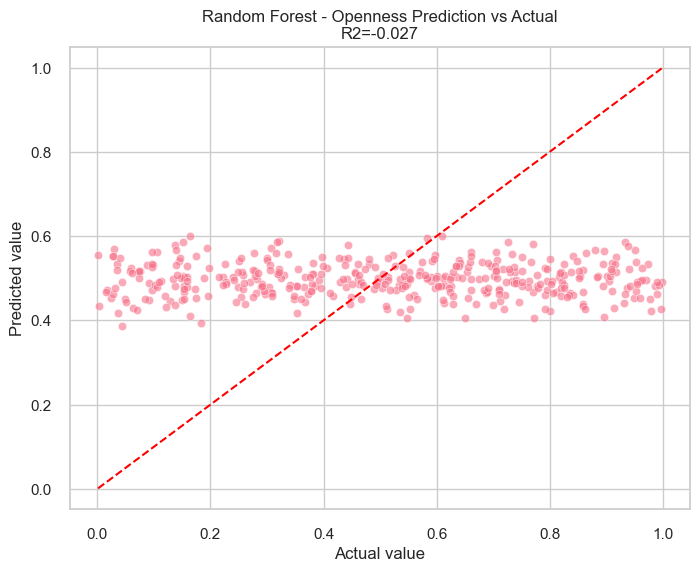

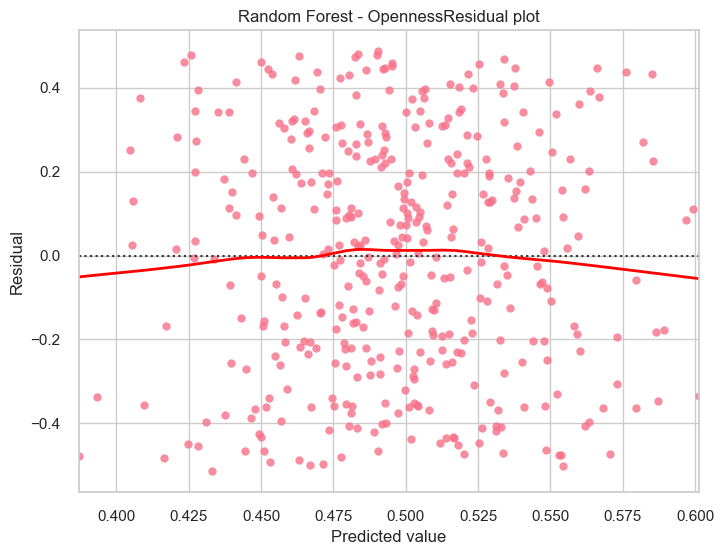

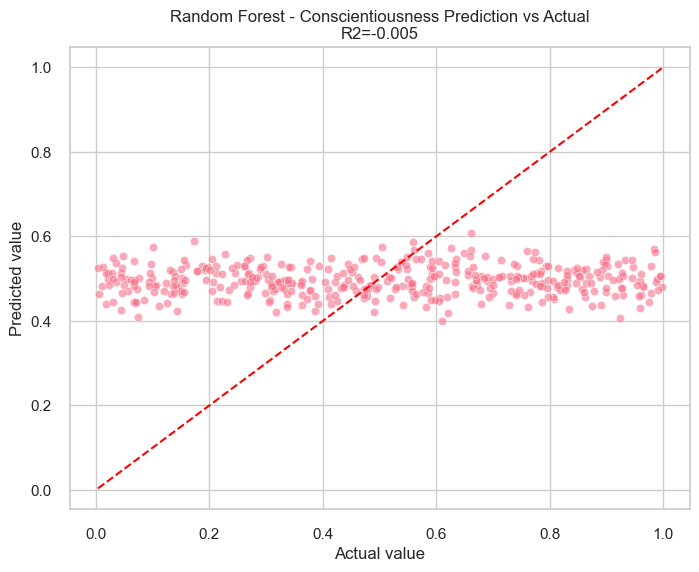

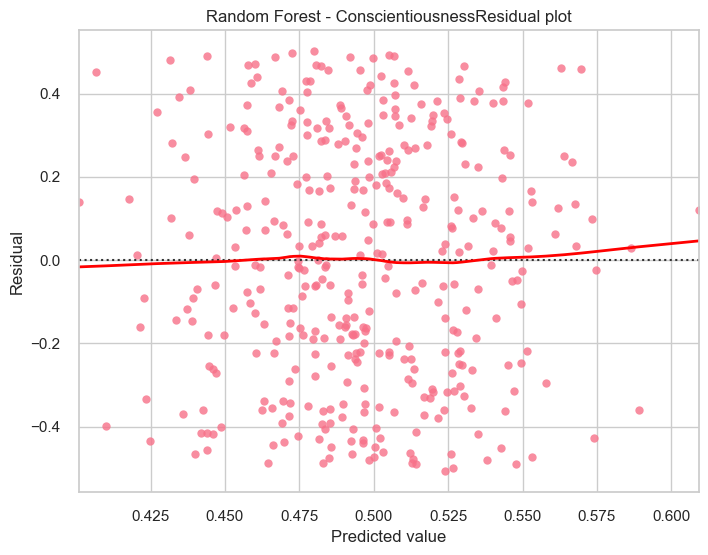

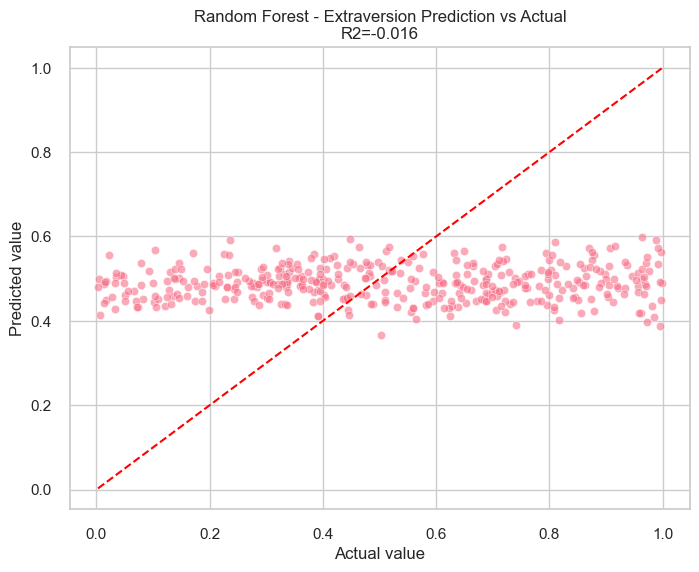

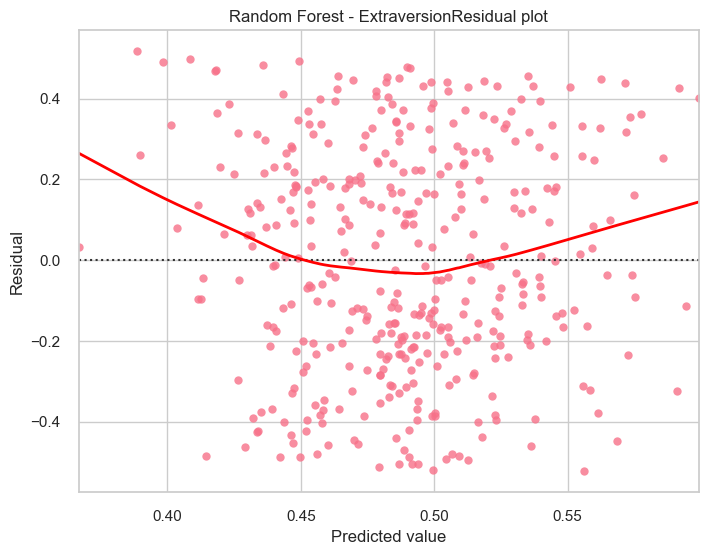

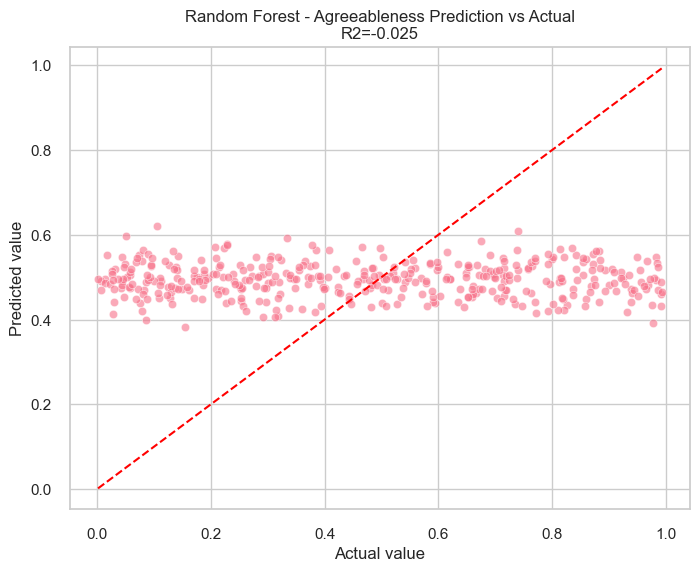

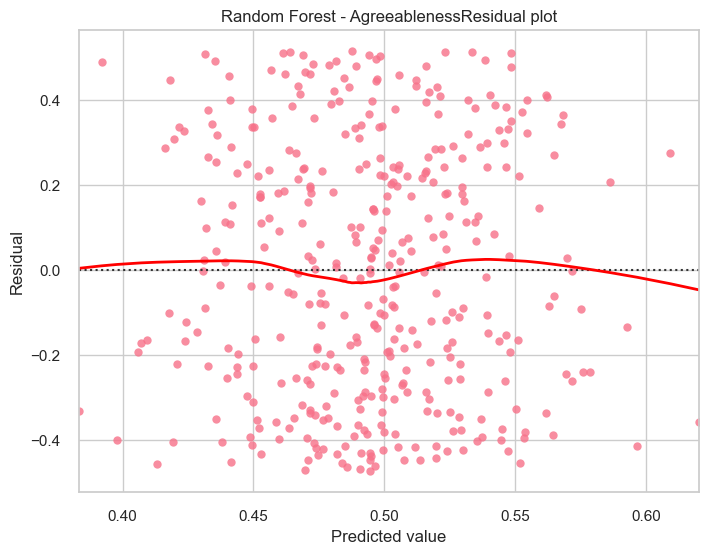

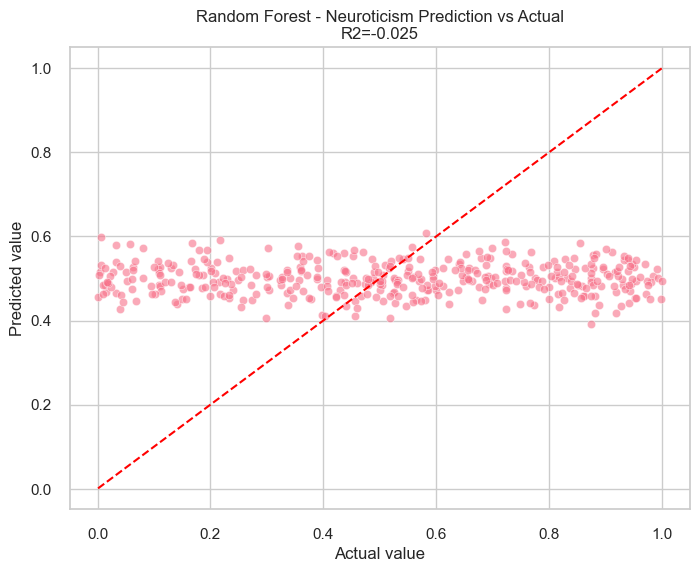

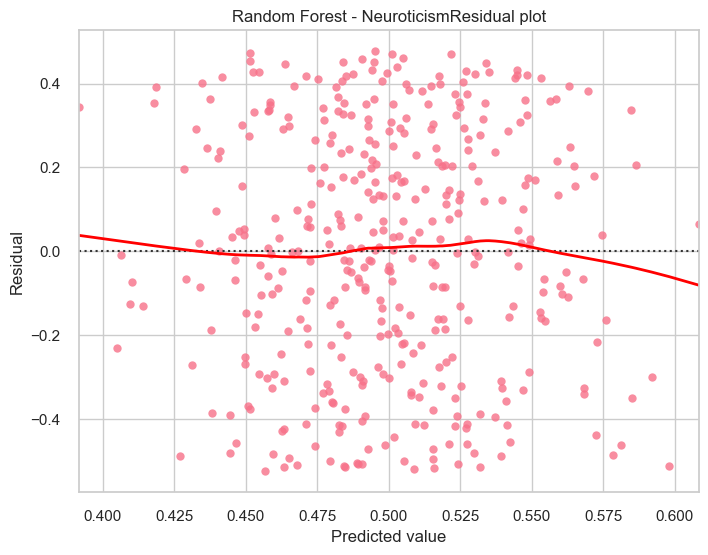


Training in progress XGBoost...


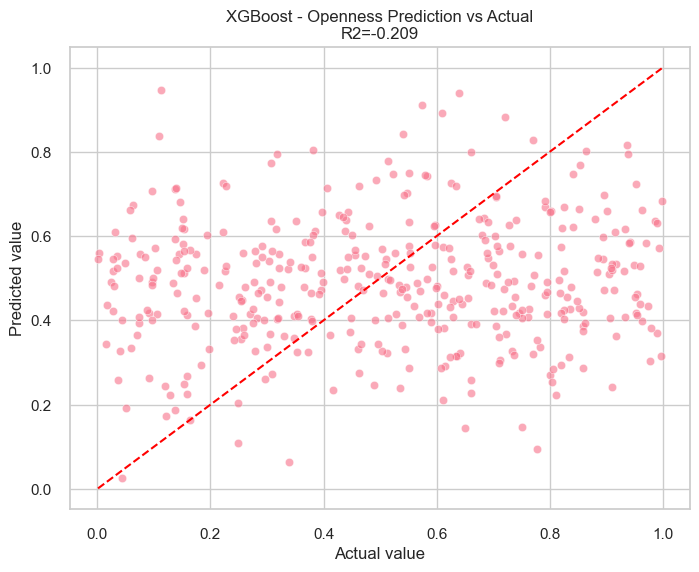

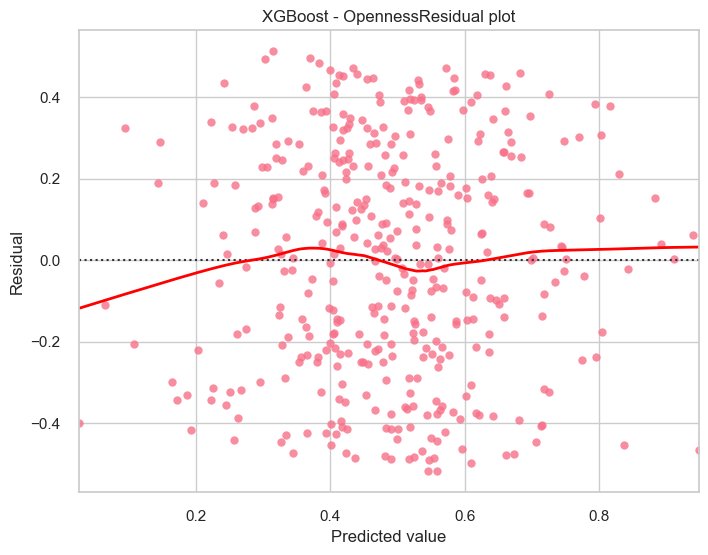

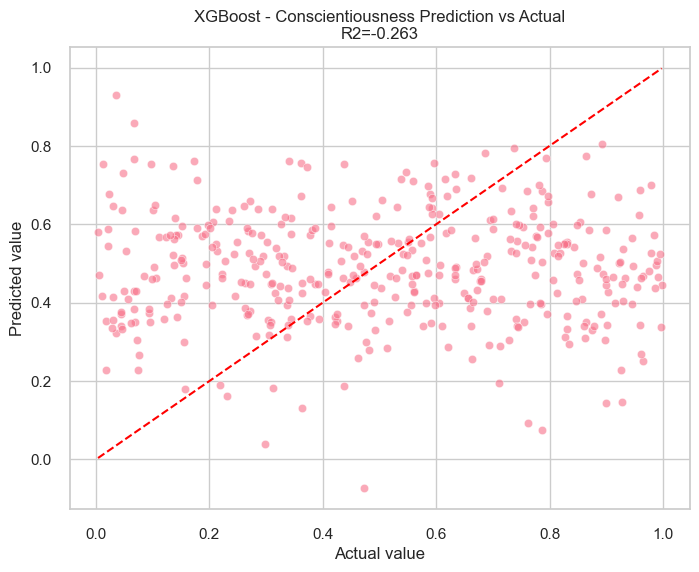

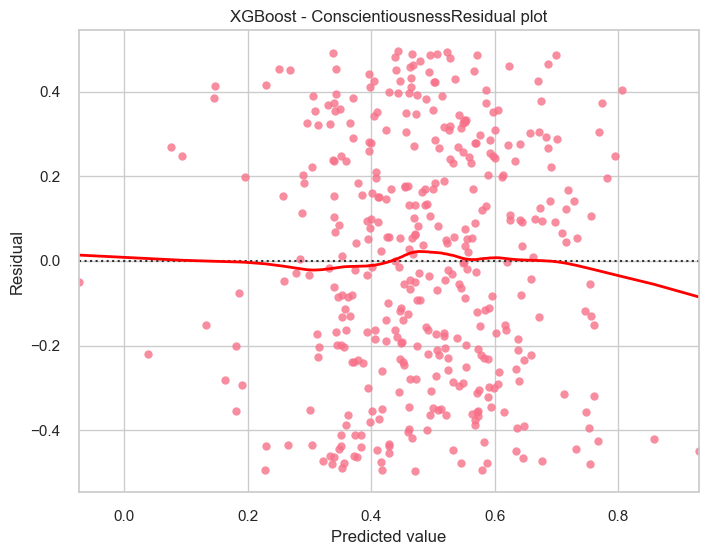

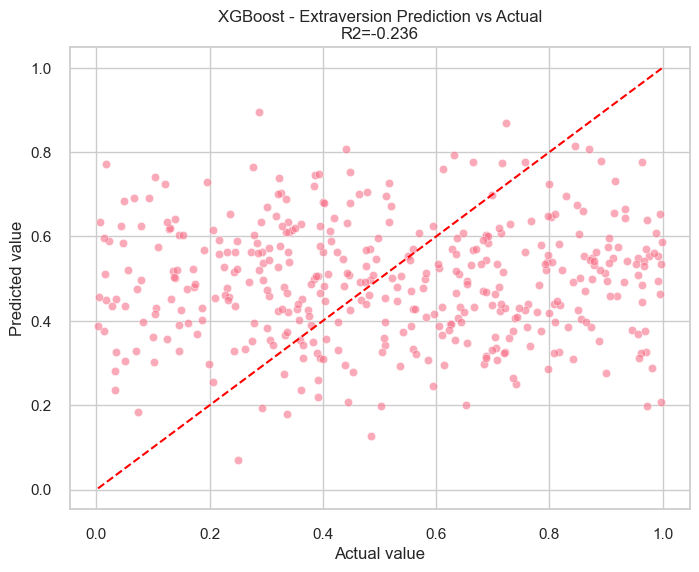

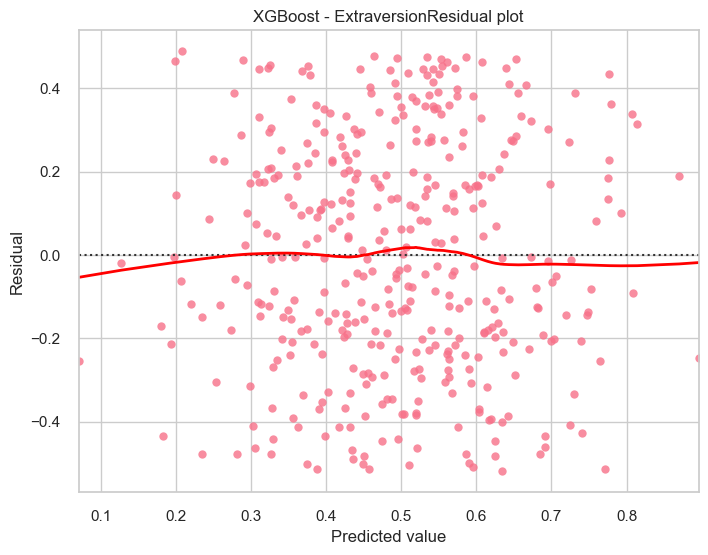

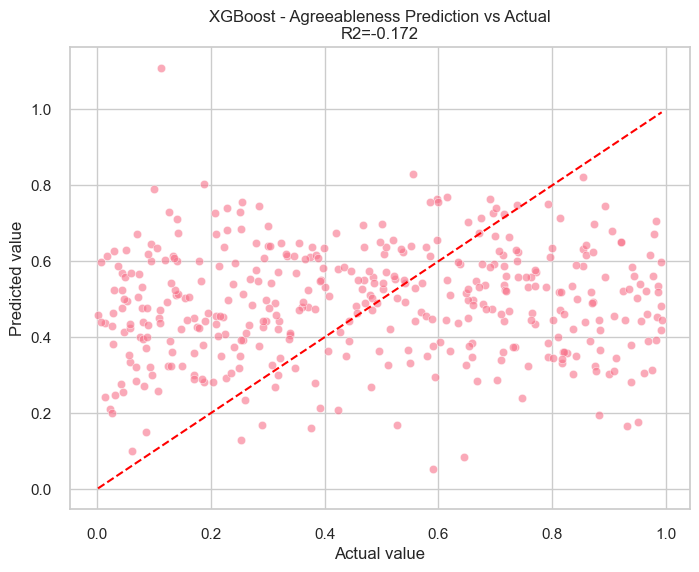

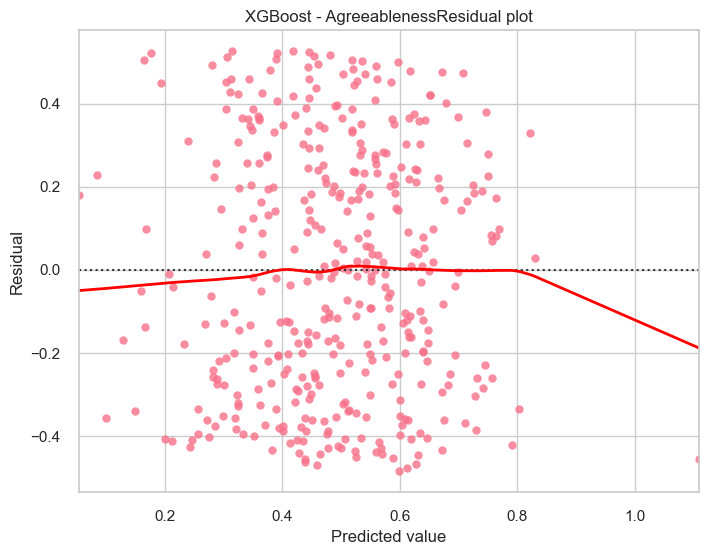

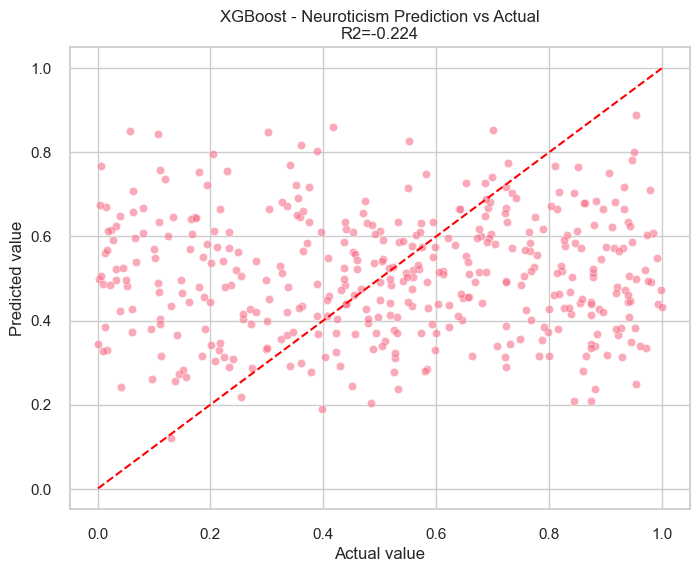

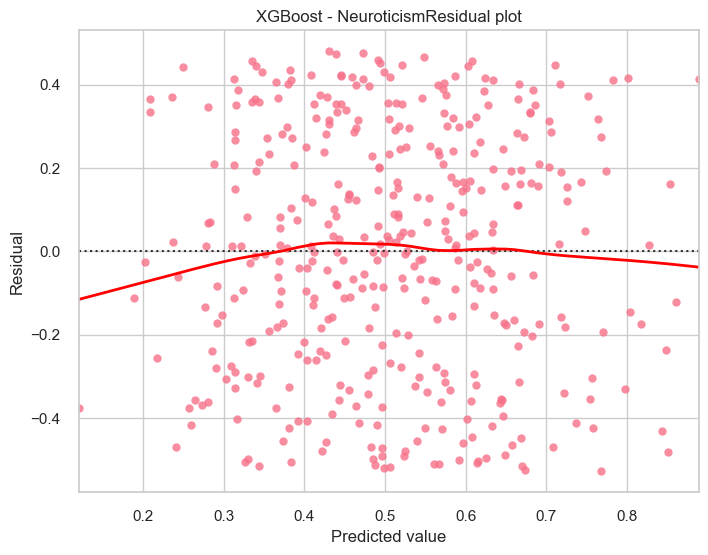


Training in progress Linear Regression...


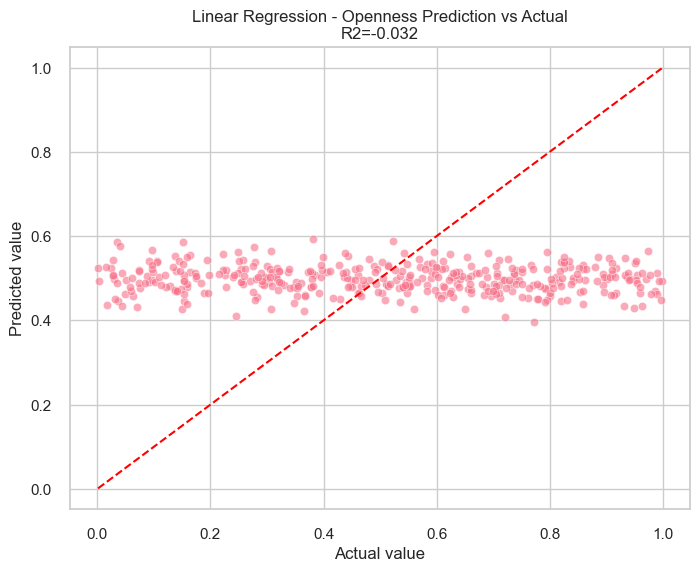

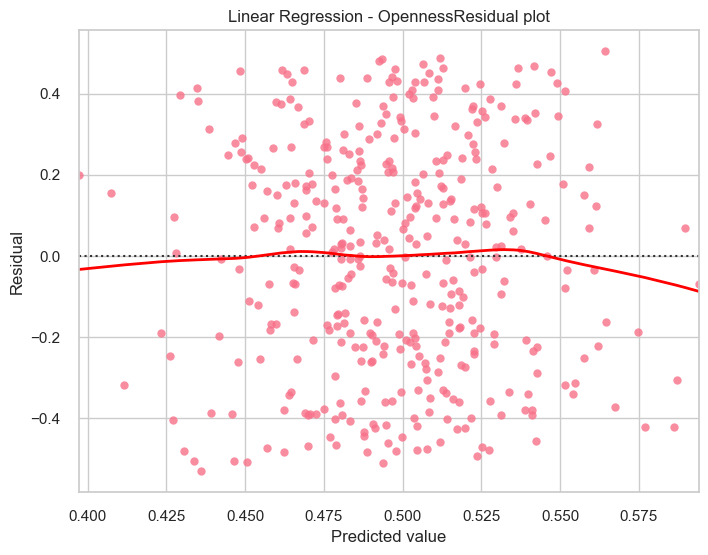

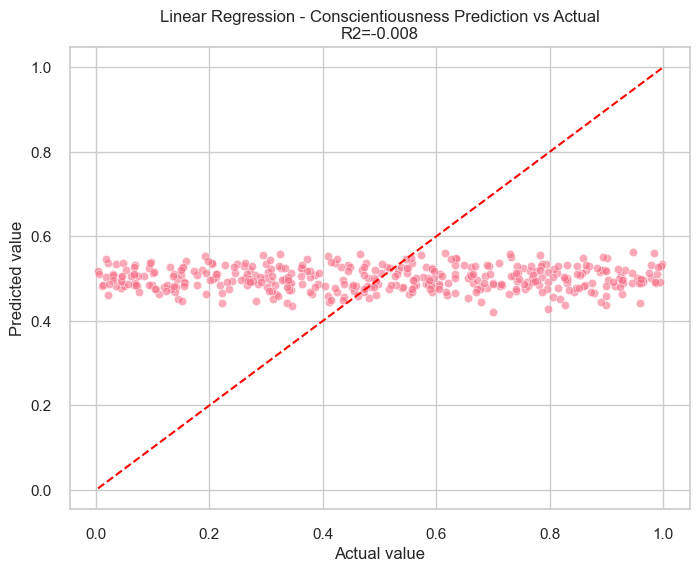

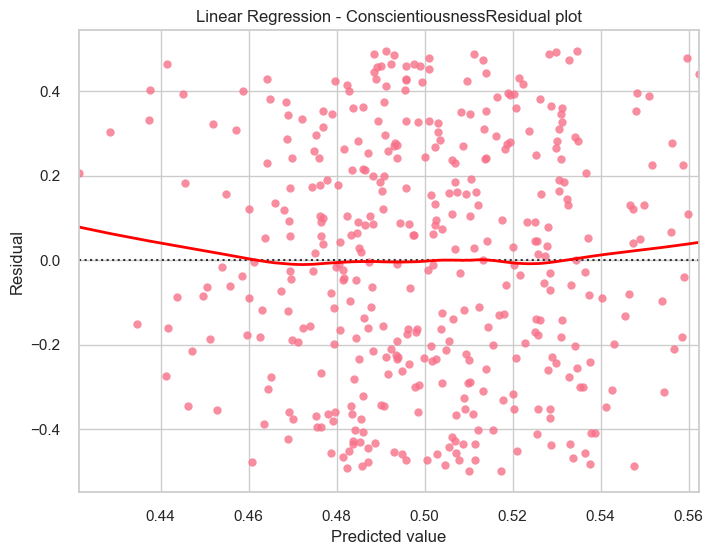

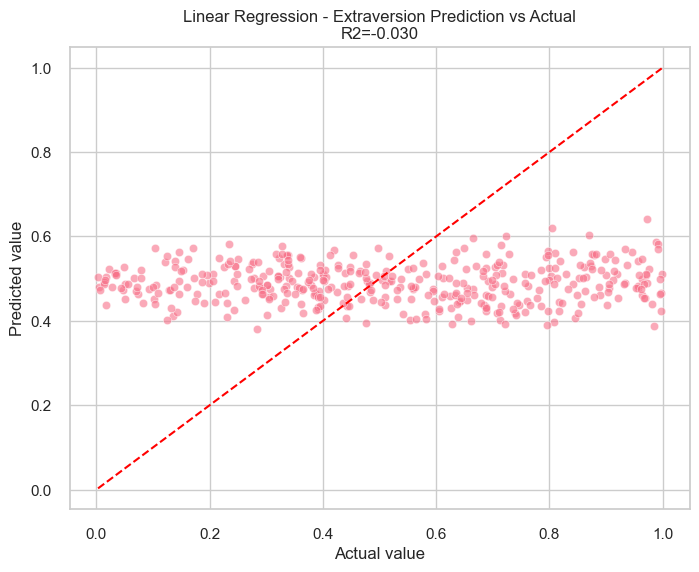

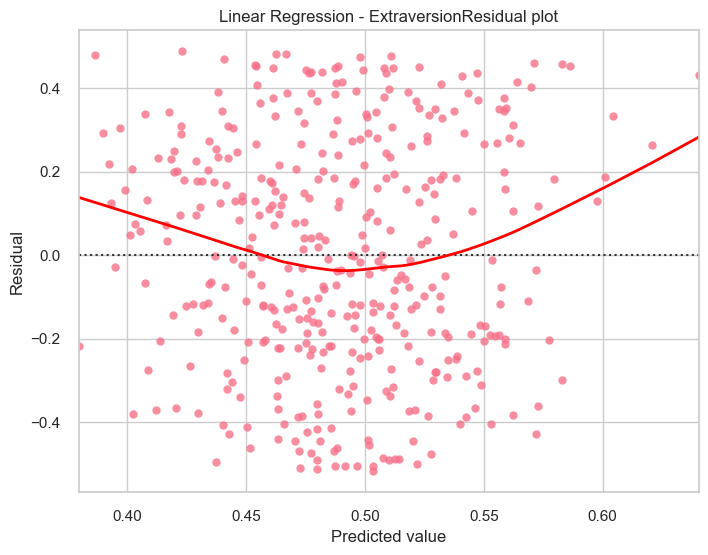

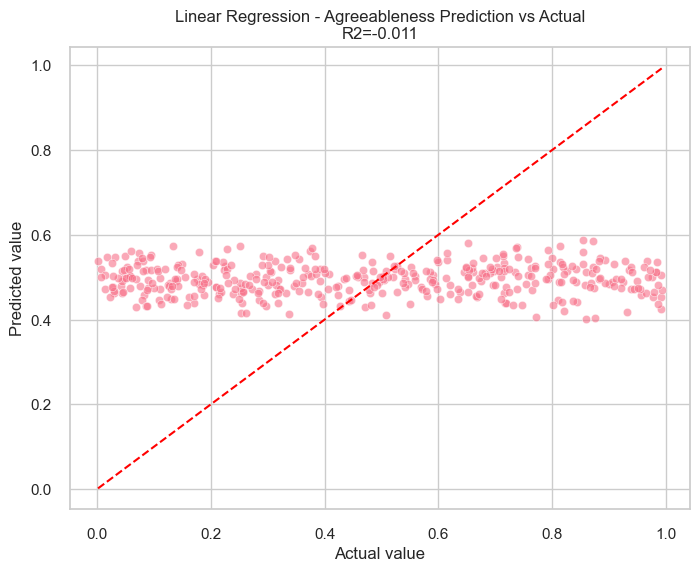

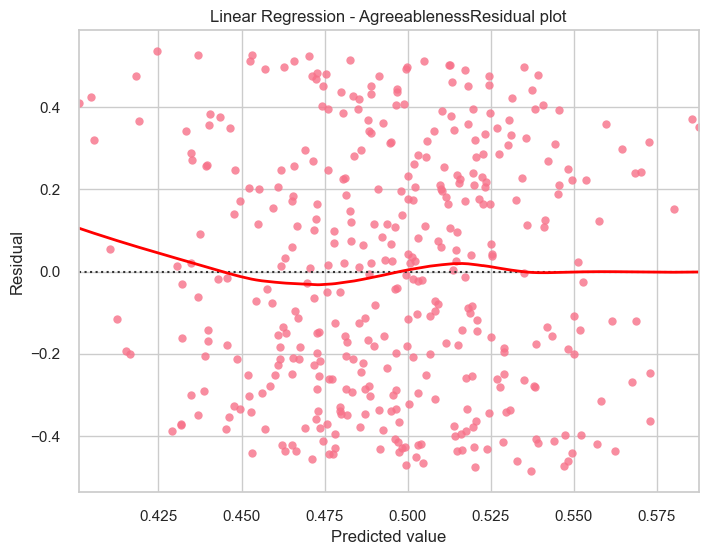

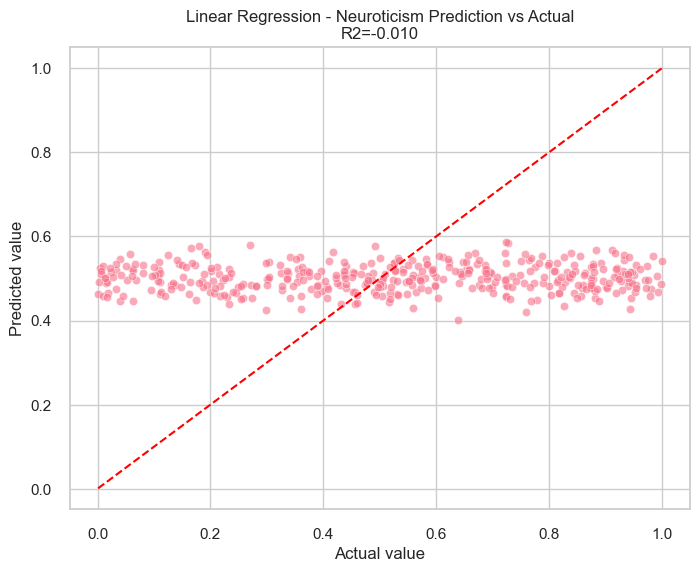

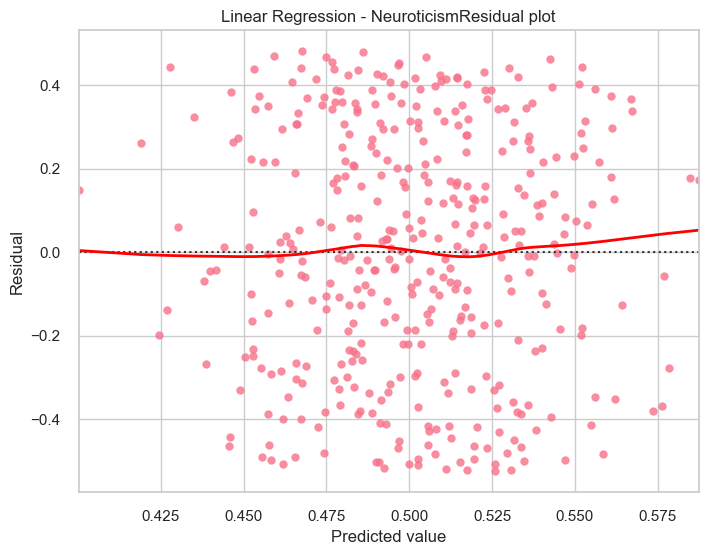


Model performance comparison:


,Model,Avg_CV_R2,CV_R2_Std,Openness_R2,Openness_MSE,Conscientiousness_R2,Conscientiousness_MSE,Extraversion_R2,Extraversion_MSE,Agreeableness_R2,Agreeableness_MSE,Neuroticism_R2,Neuroticism_MSE
0,Random Forest,-0.023,0.007,-0.027,0.080,-0.005,0.082,-0.016,0.079,-0.025,0.090,-0.025,0.086
1,XGBoost,-0.237,0.034,-0.209,0.095,-0.263,0.103,-0.236,0.096,-0.172,0.102,-0.224,0.102
2,Linear Regression,-0.017,0.005,-0.032,0.081,-0.008,0.082,-0.030,0.080,-0.011,0.088,-0.010,0.085


In [27]:
def train_evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    """
    Train, evaluate models, and generate visualizations
    Return a dictionary containing various indicators
    """
    # training model
    model.fit(X_train, y_train)
    
    # Prediction
    y_pred = model.predict(X_test)
    
    # Cross validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    
    # Calculate indicators
    metrics = {
        'Model': model_name,
        'Avg_CV_R2': np.mean(cv_scores),
        'CV_R2_Std': np.std(cv_scores)
    }
    
    # Calculate indicators for each trait
    for i, trait in enumerate(y.columns):
        metrics[f'{trait}_R2'] = r2_score(y_test[trait], y_pred[:, i])
        metrics[f'{trait}_MSE'] = mean_squared_error(y_test[trait], y_pred[:, i])
        
        # Predicted value vs Actual value graph
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=y_test[trait], y=y_pred[:, i], alpha=0.6)
        plt.plot([y_test[trait].min(), y_test[trait].max()], 
                 [y_test[trait].min(), y_test[trait].max()], 'r--')
        plt.title(f'{model_name} - {trait} Prediction vs Actual\nR2={metrics[f"{trait}_R2"]:.3f}')
        plt.xlabel("Actual value")
        plt.ylabel("Predicted value")
        plt.show()
        
        # Residual plot
        plt.figure(figsize=(8, 6))
        residuals = y_test[trait] - y_pred[:, i]
        sns.residplot(x=y_pred[:, i], y=residuals, lowess=True, 
                     line_kws={'color': 'red', 'lw': 2})
        plt.title(f'{model_name} - {trait}Residual plot')
        plt.xlabel("Predicted value")
        plt.ylabel("Residual")
        plt.show()
    
    return metrics

# Initial model
models = {
    'Random Forest': RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
    'Linear Regression': LinearRegression(n_jobs=-1)
}

# Training and Evaluating Models
results = []
for name, model in models.items():
    print(f"\nTraining in progress {name}...")
    result = train_evaluate_model(model, name, X_train_processed, X_test_processed, y_train, y_test)
    results.append(result)

# Display results
results_df = pd.DataFrame(results)
print("\nModel performance comparison:")
display(results_df.round(3))

5. Analysis of Feature Importance

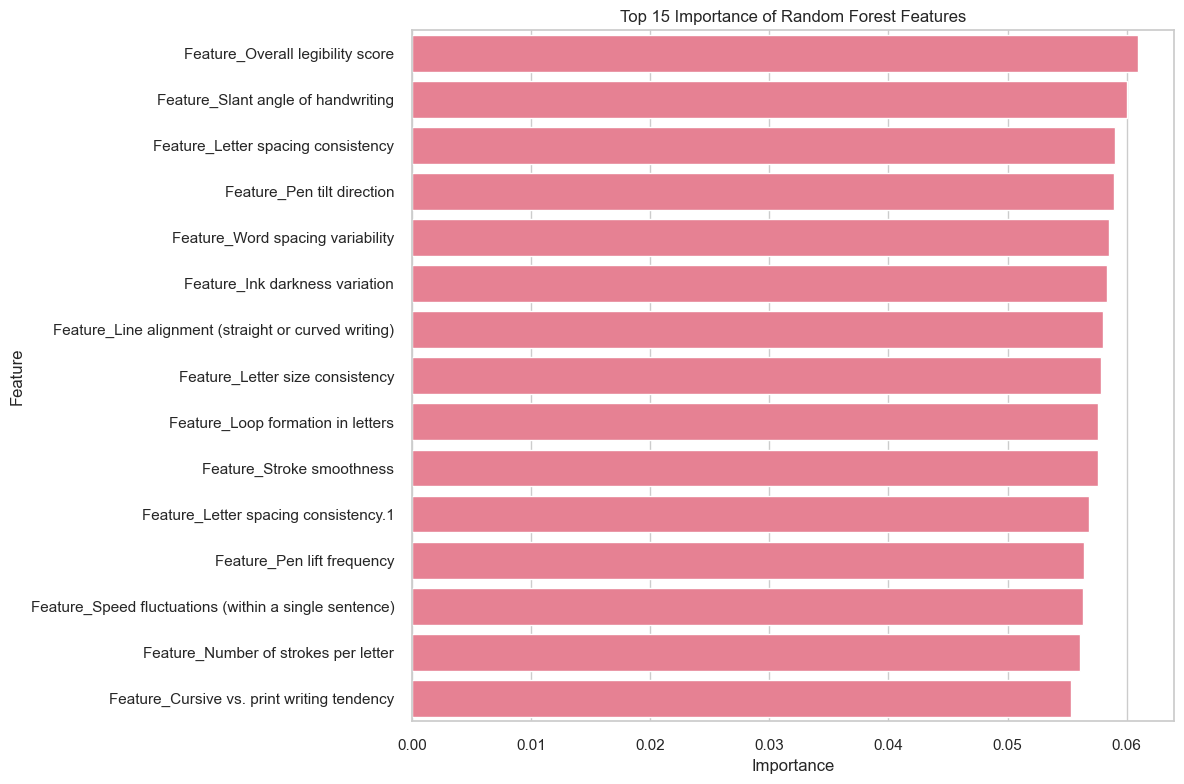

In [30]:
# Importance of Random Forest Features
rf_model = models['Random Forest']

importances = rf_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Visualize Top 15 Features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
plt.title('Top 15 Importance of Random Forest Features')
plt.tight_layout()
plt.show()

SHAP value analysis

<Figure size 1200x800 with 0 Axes>

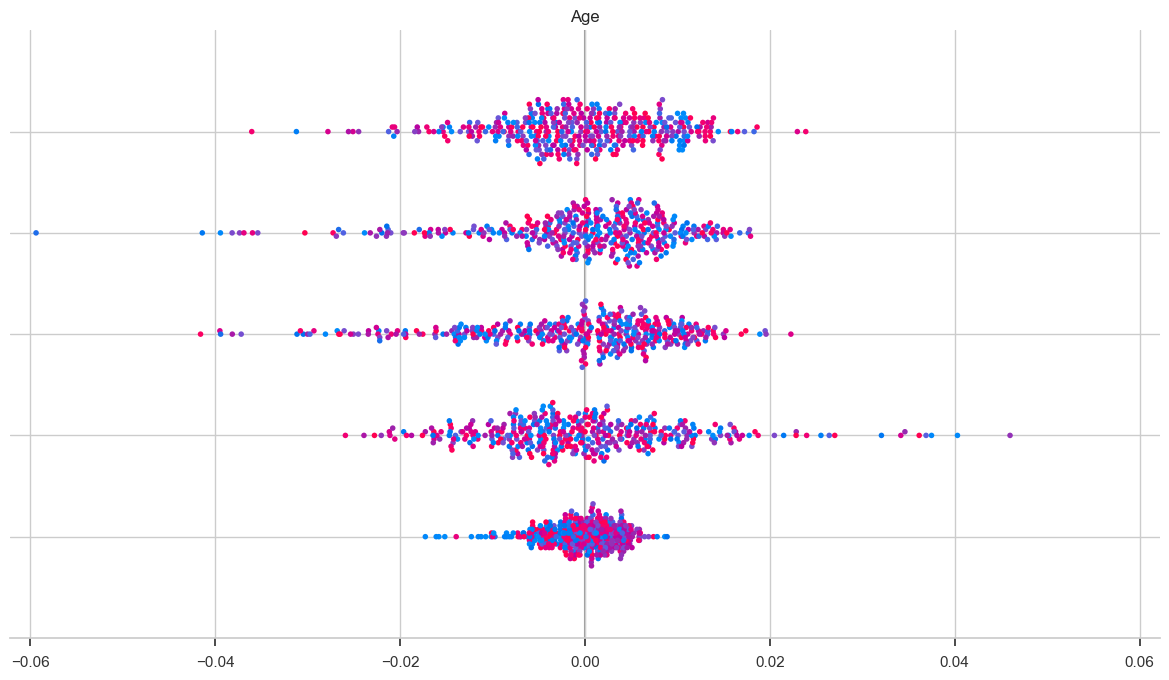

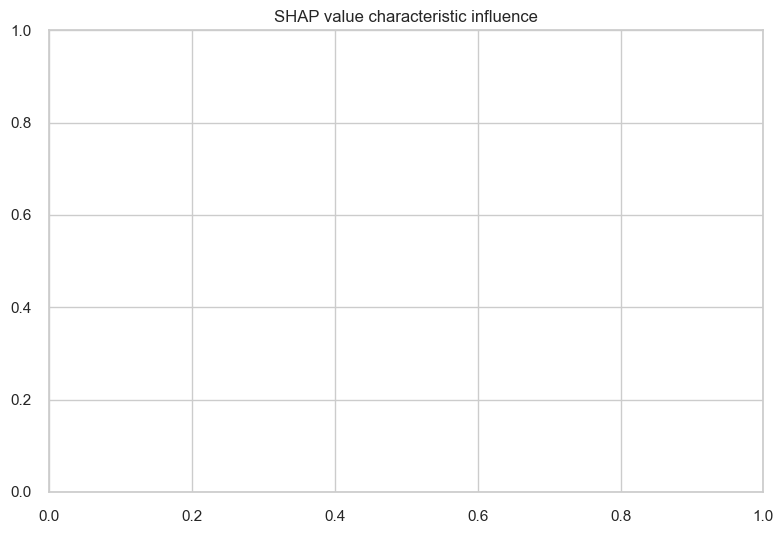

The number of features (20) does not match the SHAP value dimension (5)


In [49]:
# Calculate SHAP value
try:
    explainer = shap.TreeExplainer(rf_model)
    shap_values = explainer.shap_values(X_test_processed)
    
    # Summary diagram
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_processed, feature_names=feature_names)
    plt.title('SHAP value characteristic influence')
    plt.tight_layout()
    plt.show()
    
    # Single sample interpretation (only when dimensions match)
    sample_idx = 0
    if len(feature_names) == shap_values[0].shape[1]:
        for i, trait in enumerate(y.columns):
            print(f"\n{trait} Characteristic Explanation:")
            shap.force_plot(
                explainer.expected_value[i],
                shap_values[i][sample_idx],
                X_test_processed[sample_idx],
                feature_names=feature_names,
                matplotlib=True
            )
            plt.show()
    else:
        print(f"The number of features ({len(feature_names)}) does not match the SHAP value dimension ({shap_values[0].shape[1]})")
         
except Exception as e:
    print("SHAP analysis error:", str(e))


6. Hyperparameter tuning

Start grid search ..
Fitting 5 folds for each of 54 candidates, totalling 270 fits

Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


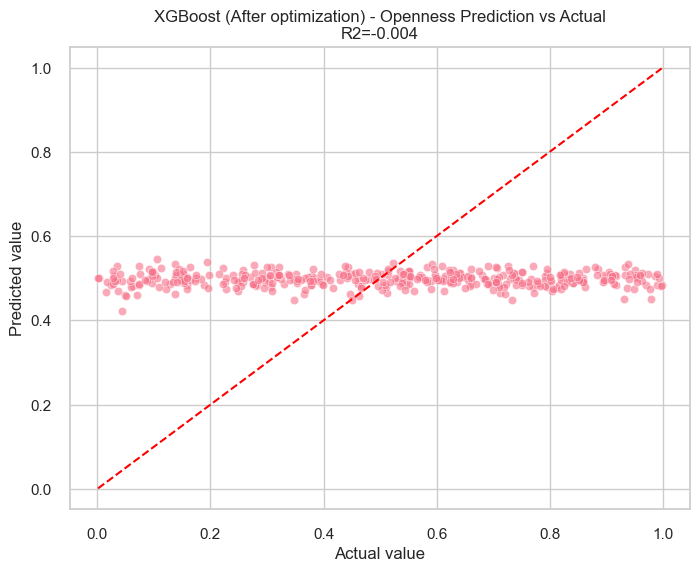

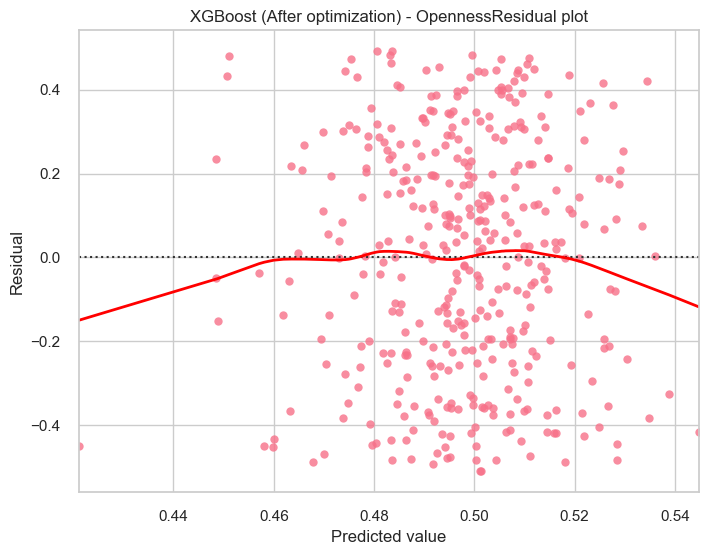

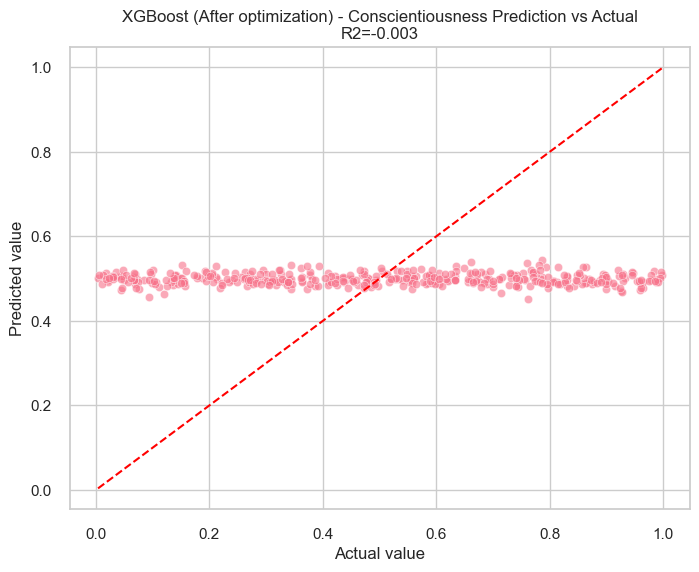

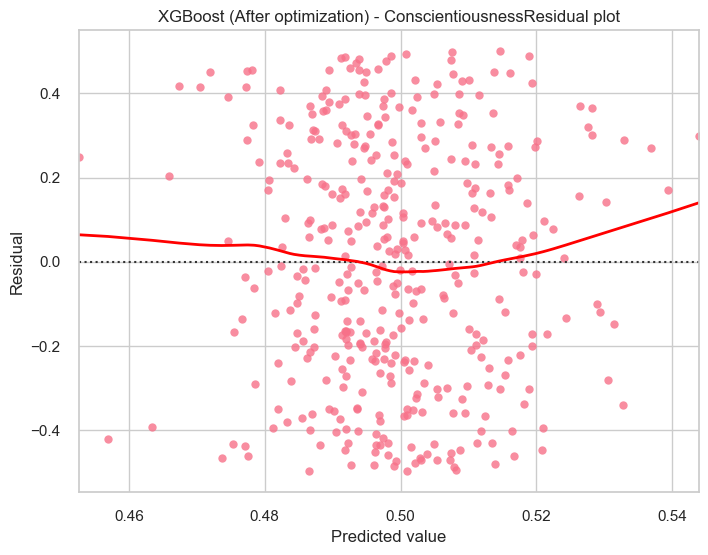

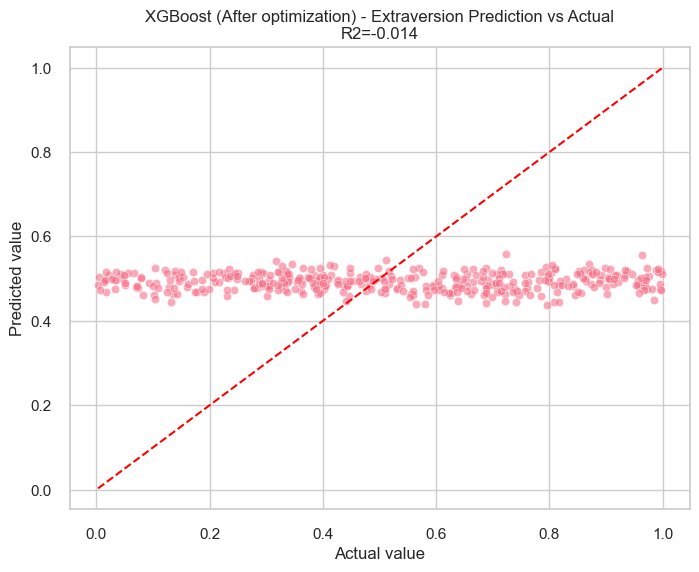

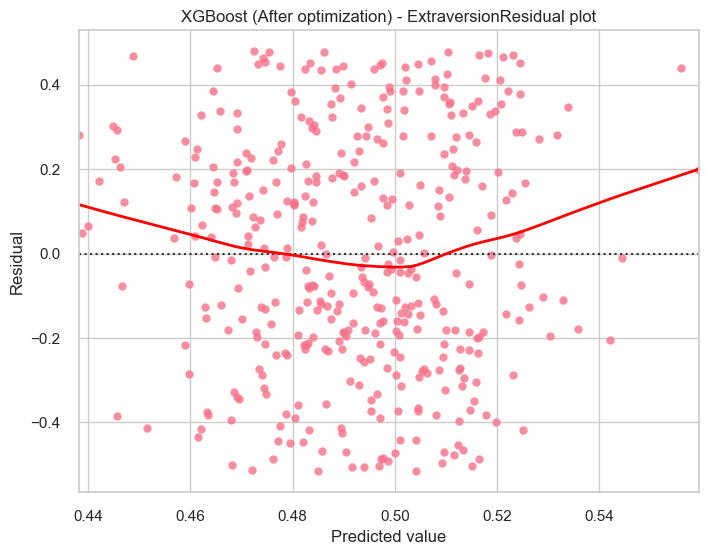

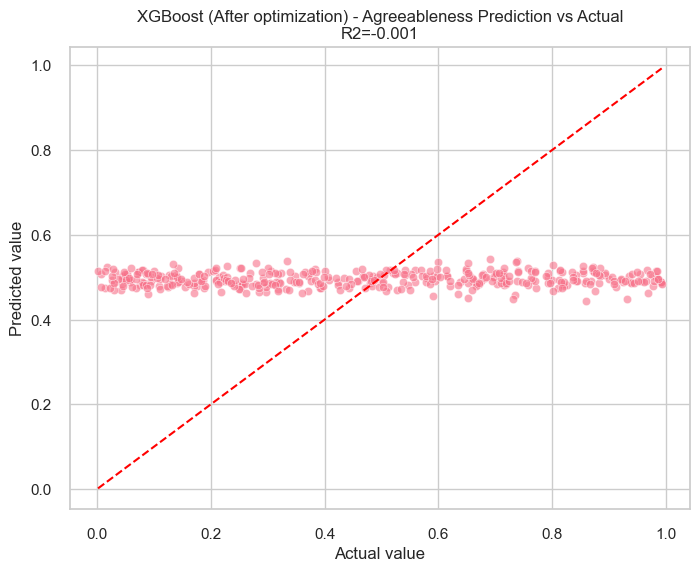

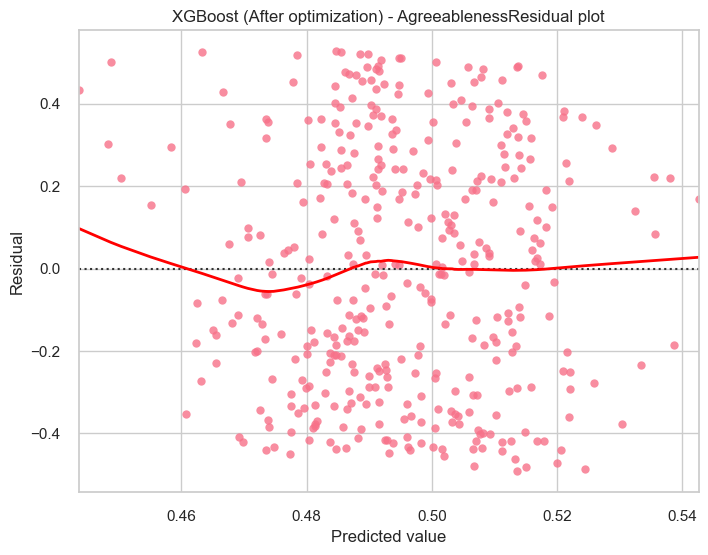

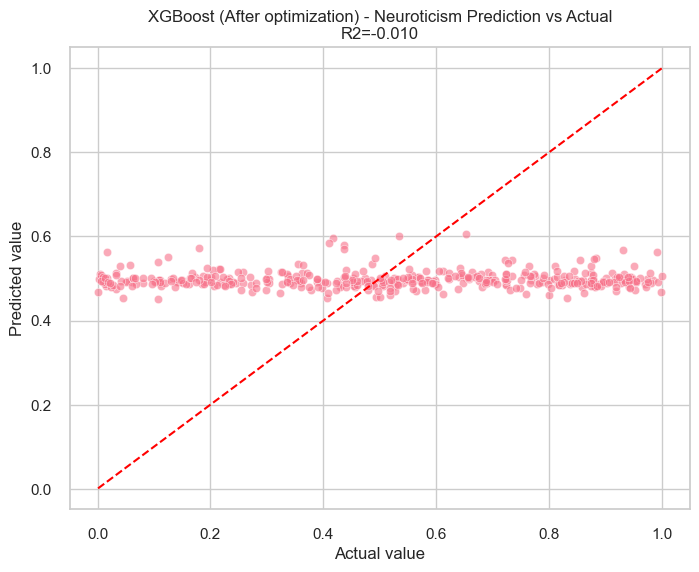

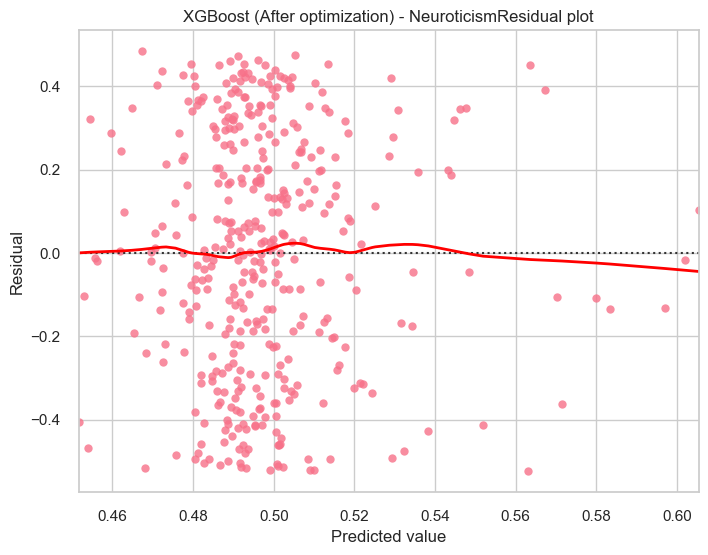

In [38]:
# XGBoost parameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

xgb = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)
grid_search = GridSearchCV(
    xgb,
    param_grid,
    cv=5,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

print("Start grid search ..")
grid_search.fit(X_train_processed, y_train)

# Display optimal parameters
print("\nBest parameters:", grid_search.best_params_)

# Evaluate the best model
best_model = grid_search.best_estimator_
best_metrics = train_evaluate_model(best_model, "XGBoost (After optimization)", 
                                  X_train_processed, X_test_processed, 
                                  y_train, y_test)


7. Summary of Results and Suggestions

In [40]:
# Merge all results
final_results = pd.concat([results_df, pd.DataFrame([best_metrics])], ignore_index=True)
print("\nPerformance comparison of all models:")
display(final_results.round(3))



Performance comparison of all models:


,Model,Avg_CV_R2,CV_R2_Std,Openness_R2,Openness_MSE,Conscientiousness_R2,Conscientiousness_MSE,Extraversion_R2,Extraversion_MSE,Agreeableness_R2,Agreeableness_MSE,Neuroticism_R2,Neuroticism_MSE
0,Random Forest,-0.023,0.007,-0.027,0.080,-0.005,0.082,-0.016,0.079,-0.025,0.090,-0.025,0.086
1,XGBoost,-0.237,0.034,-0.209,0.095,-0.263,0.103,-0.236,0.096,-0.172,0.102,-0.224,0.102
2,Linear Regression,-0.017,0.005,-0.032,0.081,-0.008,0.082,-0.030,0.080,-0.011,0.088,-0.010,0.085
3,XGBoost (After optimization),-0.008,0.003,-0.004,0.079,-0.003,0.082,-0.014,0.078,-0.001,0.087,-0.010,0.085


Key findings
1. Best Model: XGBoost (After optimization) performs the best on average cross validation R ²
2. The easiest trait to predict: Agreeableness (R ²=-0.001)
3. The most unpredictable trait: Extraversion (R² = -0.014)
4. Important characteristics: Feature_Overall legibility score, Feature_Slant angle of handwriting, Feature_Letter spacing consistency, Feature_Pen tilt direction, Feature_Word spacing variability

8. Project Preservation

In [43]:
# Save the best model
import joblib

joblib.dump({
    'model': best_model,
    'preprocessor': preprocessor,
    'feature_names': feature_names
}, 'best_model.pkl')

print("The model has been saved as best_model.pkl")

The model has been saved as best_model.pkl


Model selection and reasons
In this project, we compared and evaluated three mainstream regression models: Random Forest Regression, XGBoost Regression (Extreme Gradient Boosting Regression), and Linear Regression, which represent ensemble learning, gradient boosting, and basic linear modeling methods, respectively.

We ultimately chose XGBoost (optimized) as the best model for this project for the following reasons:

Superior prediction performance: Among the five personality traits predicted, the optimized XGBoost model is superior to other models in terms of average R ² score and mean square error (MSE), especially in terms of Consistent ness and Openness.

Strong robustness and good generalization ability: XGBoost has excellent regularization mechanisms (L1 and L2), which can effectively prevent overfitting. It also performs stably in cross validation with low standard deviation.

Flexible feature processing: XGBoost can automatically handle non-linear feature relationships, is insensitive to feature scaling, and can also handle high-dimensional sparse data well.

Strong tuning ability: Compared to random forests and linear regression, XGBoost provides more tuning space (such as learning rate, subsample ratio, maximum depth, etc.), which can further optimize model performance through grid search.

Good compatibility and strong interpretability: XGBoost can seamlessly integrate with SHAP tools, facilitating model interpretability analysis and helping us identify key handwritten features that affect personality traits.

Overall, the XGBoost (optimized) model has achieved a good balance between performance and interpretability, making it the most suitable final model for this project.